In [1]:
import pickle

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, MaxPool2D, Conv2D, Flatten, Input, Dropout, BatchNormalization

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

print(tf.__version__)

2.8.0


In [2]:
AUTOTUNE = tf.data.AUTOTUNE

## 1. Load data

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
qmnist = unpickle("data/MNIST-120k")

In [4]:
data = qmnist['data']
labels = qmnist['labels']
len(data), len(labels)

(120000, 120000)

## 2. Preprocess data

In [5]:
data = data / 255.

In [6]:
data.shape, labels.shape

((120000, 28, 28), (120000, 1))

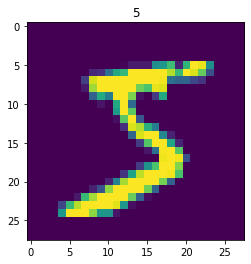

In [7]:
plt.imshow(data[0])
plt.title(labels[0][0]);

In [8]:
data[0].shape, labels[0]

((28, 28), array([5]))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=42, shuffle=True, test_size=0.2)
len(X_train), len(X_test), len(y_train), len(y_test)

(96000, 24000, 96000, 24000)

In [10]:
X_train.shape, y_train.shape

((96000, 28, 28), (96000, 1))

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(80).cache().prefetch(AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(80).cache().prefetch(AUTOTUNE)

train_ds, val_ds

2022-05-02 16:16:41.139212: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>)

## 3. Experiment 1: Convolution subsampling pairs

* 1 subsampling pair -> `Conv2D` x `MaxPool2D` -> `Flatten()`

* 2 subsampling pairs -> (`Conv2D` x `MaxPool2D`) * 2 -> `Flatten()`

* 3 subsampling pairs -> (`Conv2D` x `MaxPool2D`) * 3 -> `Flatten()`

In [12]:
lrscheduler = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

### Model 0: 1 sub-sampling layer

In [13]:
inputs = Input(shape=(28, 28, 1), dtype=tf.float32)
x = Conv2D(24, kernel_size=5, padding="same", activation="relu")(inputs)
x = MaxPool2D()(x)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
outputs = Dense(10, activation="softmax")(x)
model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 24)        624       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 24)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4704)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1204480   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 1,207,674
Trainable params: 1,207,674
Non-trainable params: 0
___________________________________________________

In [14]:
model_0_history = model_0.fit(
    train_ds,
    steps_per_epoch=len(train_ds),
    epochs=20,
    validation_data=val_ds,
    validation_steps=len(val_ds),
    callbacks=[lrscheduler]
)

Epoch 1/20


2022-04-29 06:49:41.184410: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-29 06:49:41.987458: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1200/1200 [==============================] - 11s 4ms/step - loss: 0.1236 - accuracy: 0.9622 - val_loss: 0.0526 - val_accuracy: 0.9832
Epoch 2/20
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0383 - accuracy: 0.9883 - val_loss: 0.0397 - val_accuracy: 0.9872
Epoch 3/20
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0245 - accuracy: 0.9925 - val_loss: 0.0431 - val_accuracy: 0.9871
Epoch 4/20
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0155 - accuracy: 0.9955 - val_loss: 0.0435 - val_accuracy: 0.9872
Epoch 5/20
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0101 - accuracy: 0.9969 - val_loss: 0.0445 - val_accuracy: 0.9884
Epoch 6/20
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0070 - accuracy: 0.9979 - val_loss: 0.0473 - val_accuracy: 0.9883
Epoch 7/20
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0056 - accuracy: 0.9981 - val_loss: 0.0443 - val_accuracy: 0.9892
Ep

### Model 1

In [15]:
inputs = Input(shape=(28, 28, 1), dtype=tf.float32)
x = Conv2D(24, kernel_size=5, padding="same", activation="relu")(inputs)
x = MaxPool2D()(x)

# add more sub-sampling layers
x = Conv2D(48, kernel_size=5, padding="same", activation="relu")(x)
x = MaxPool2D()(x)

x = Flatten()(x)
x = Dense(256, activation="relu")(x)
outputs = Dense(10, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 24)        624       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 48)        28848     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 48)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6023

In [16]:
model_1_history = model_1.fit(
    train_ds,
    steps_per_epoch=len(train_ds),
    epochs=20,
    validation_data=val_ds,
    validation_steps=len(val_ds),
    callbacks=[lrscheduler]
)

Epoch 1/20
1200/1200 [==============================] - 5s 4ms/step - loss: 0.1095 - accuracy: 0.9659 - val_loss: 0.0407 - val_accuracy: 0.9872
Epoch 2/20
1200/1200 [==============================] - 5s 4ms/step - loss: 0.0335 - accuracy: 0.9891 - val_loss: 0.0351 - val_accuracy: 0.9893
Epoch 3/20
1200/1200 [==============================] - 5s 4ms/step - loss: 0.0220 - accuracy: 0.9932 - val_loss: 0.0365 - val_accuracy: 0.9899
Epoch 4/20
1200/1200 [==============================] - 5s 4ms/step - loss: 0.0149 - accuracy: 0.9953 - val_loss: 0.0381 - val_accuracy: 0.9894
Epoch 5/20
1200/1200 [==============================] - 5s 4ms/step - loss: 0.0105 - accuracy: 0.9966 - val_loss: 0.0464 - val_accuracy: 0.9890
Epoch 6/20
1200/1200 [==============================] - 5s 4ms/step - loss: 0.0093 - accuracy: 0.9967 - val_loss: 0.0386 - val_accuracy: 0.9911
Epoch 7/20
1200/1200 [==============================] - 5s 4ms/step - loss: 0.0062 - accuracy: 0.9979 - val_loss: 0.0390 - val_accuracy:

### Model 2

In [17]:
inputs = Input(shape=(28, 28, 1), dtype=tf.float32)
x = Conv2D(24, kernel_size=5, padding="same", activation="relu")(inputs)
x = MaxPool2D()(x)
x = Conv2D(48, kernel_size=5, padding="same", activation="relu")(x) 
x = MaxPool2D()(x)

# add more sub-sampling layers
x = Conv2D(64, kernel_size=5, padding="same", activation="relu")(x)
x = MaxPool2D(padding="same")(x)

x = Flatten()(x)
x = Dense(256, activation="relu")(x)
outputs = Dense(10, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 24)        624       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 24)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 48)        28848     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 48)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          76864     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)          0   

In [18]:
model_2_history = model_2.fit(
    train_ds,
    steps_per_epoch=len(train_ds),
    epochs=20,
    validation_data=val_ds,
    validation_steps=len(val_ds),
    callbacks=[lrscheduler]
)

Epoch 1/20
1200/1200 [==============================] - 6s 4ms/step - loss: 0.1116 - accuracy: 0.9645 - val_loss: 0.0386 - val_accuracy: 0.9878
Epoch 2/20
1200/1200 [==============================] - 5s 4ms/step - loss: 0.0324 - accuracy: 0.9895 - val_loss: 0.0282 - val_accuracy: 0.9912
Epoch 3/20
1200/1200 [==============================] - 5s 4ms/step - loss: 0.0223 - accuracy: 0.9928 - val_loss: 0.0352 - val_accuracy: 0.9899
Epoch 4/20
1200/1200 [==============================] - 6s 5ms/step - loss: 0.0158 - accuracy: 0.9949 - val_loss: 0.0335 - val_accuracy: 0.9910
Epoch 5/20
1200/1200 [==============================] - 6s 5ms/step - loss: 0.0126 - accuracy: 0.9960 - val_loss: 0.0351 - val_accuracy: 0.9910
Epoch 6/20
1200/1200 [==============================] - 5s 4ms/step - loss: 0.0097 - accuracy: 0.9967 - val_loss: 0.0352 - val_accuracy: 0.9917
Epoch 7/20
1200/1200 [==============================] - 5s 4ms/step - loss: 0.0075 - accuracy: 0.9975 - val_loss: 0.0360 - val_accuracy:

### Altogether training

For the rest of the experiments, we are going to create models with the same architecture but with a little bit of customization on each layer features/adding more layers so that we do not need to create a new model everytime, instead, we are going to create multiple models within a for loop as this will iterate our experiments quickly.

In [21]:
nn = 3
models = [0] * nn

tf.random.set_seed(42)

for i in range(nn):
    inputs = Input(shape=(28, 28, 1), dtype=tf.float32)
    x = Conv2D(24, kernel_size=5, padding="same", activation="relu")(inputs)
    x = MaxPool2D()(x)
    
    # model 2 (2 ss layers)
    if i > 0:
        x = Conv2D(48, kernel_size=5, padding="same", activation="relu")(x) 
        x = MaxPool2D()(x)

    # model 3 (3 ss layers)
    if i > 1:
        x = Conv2D(64, kernel_size=5, padding="same", activation="relu")(x)
        x = MaxPool2D(padding="same")(x)

    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    outputs = Dense(10, activation="softmax")(x)
    models[i] = tf.keras.Model(inputs, outputs)

    models[i].compile(
        loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )

    models[i].summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 24)        624       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 24)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4704)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               1204480   
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2570      
Total params: 1,207,674
Trainable params: 1,207,674
Non-trainable params: 0
_________________________________________________

In [22]:
models_history = [0] * nn
models_type = ["1_sub-sampling","2_sub-sampling","3_sub-sampling"]

for i in range(nn):
    models_history[i] = models[i].fit(
        train_ds,
        steps_per_epoch=len(train_ds),
        epochs=20,
        validation_data=val_ds,
        validation_steps=len(val_ds),
        callbacks=[lrscheduler], 
        verbose=0
    )
    print(f"{models_type[i]}: Epochs={20}, Train accuracy={max(models_history[i].history['accuracy']):.5f}, Validation accuracy={max(models_history[i].history['val_accuracy']):.5f}")
    print()

1_sub-sampling: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99221

2_sub-sampling: Epochs=20, Train accuracy=0.99995, Validation accuracy=0.99392

3_sub-sampling: Epochs=20, Train accuracy=0.99974, Validation accuracy=0.99317



### Compare results

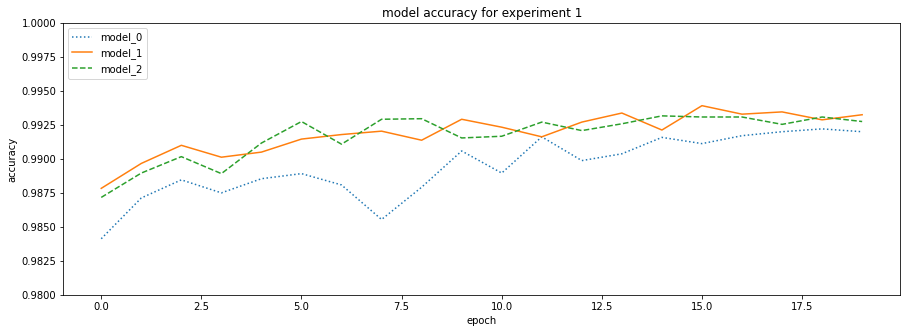

In [23]:
plt.figure(figsize=(15,5))

plt.plot(models_history[0].history['val_accuracy'], linestyle=':')
plt.plot(models_history[1].history['val_accuracy'], linestyle='-')
plt.plot(models_history[2].history['val_accuracy'], linestyle='--')

plt.title('model accuracy for experiment 1')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['model_0', 'model_1', 'model_2'], loc='upper left')

axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

## 4. Experiment 2: Feature Maps

Feauture maps are the `Conv2D(feature_maps, padding, stride, ...etc)` filter values.

In this experiment we are using a pair of a sub-sampling layer.

Feature maps that we are going to explore are:
* Model 0: Sub-sampling layers of `0*8+8` x `0*16+16`
* Model 1: Sub-sampling layers of `1*8+8` x `1*16+16`
* Model 2: Sub-sampling layers of `2*8+8` x `2*16+16`
* Model 3: Sub-sampling layers of `3*8+8` x `3*16+16`
* Model 4: Sub-sampling layers of `4*8+8` x `4*16+16`
* Model 5: Sub-sampling layers of `5*8+8` x `5*16+16`

In [24]:
nn = 6
models = [0] * nn

tf.random.set_seed(42)

for i in range(nn):
    inputs = Input(shape=(28, 28, 1), dtype=tf.float32)
    
    x = Conv2D(i*8+8, kernel_size=5, padding="same", activation="relu")(inputs)
    x = MaxPool2D()(x)

    x = Conv2D(i*16+16, kernel_size=5, padding="same", activation="relu")(x) 
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    outputs = Dense(10, activation="softmax")(x)
    models[i] = tf.keras.Model(inputs, outputs)

    models[i].compile(
        loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )

    models[i].summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 8)         208       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 16)        3216      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               2009

In [25]:
models_history = [0] * nn
models_type = ["8 maps","16 maps","24 maps","32 maps","40 maps","48 maps"]

for i in range(nn):
    models_history[i] = models[i].fit(
        train_ds,
        steps_per_epoch=len(train_ds),
        epochs=20,
        validation_data=val_ds,
        validation_steps=len(val_ds),
        callbacks=[lrscheduler], 
        verbose=0
    )
    print(f"{models_type[i]}: Epochs={20}, Train accuracy={max(models_history[i].history['accuracy']):.5f}, Validation accuracy={max(models_history[i].history['val_accuracy']):.5f}")
    print()

8 maps: Epochs=20, Train accuracy=0.99980, Validation accuracy=0.99246

16 maps: Epochs=20, Train accuracy=0.99984, Validation accuracy=0.99379

24 maps: Epochs=20, Train accuracy=0.99986, Validation accuracy=0.99358

32 maps: Epochs=20, Train accuracy=0.99992, Validation accuracy=0.99388

48 maps: Epochs=20, Train accuracy=0.99983, Validation accuracy=0.99408

64 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99529



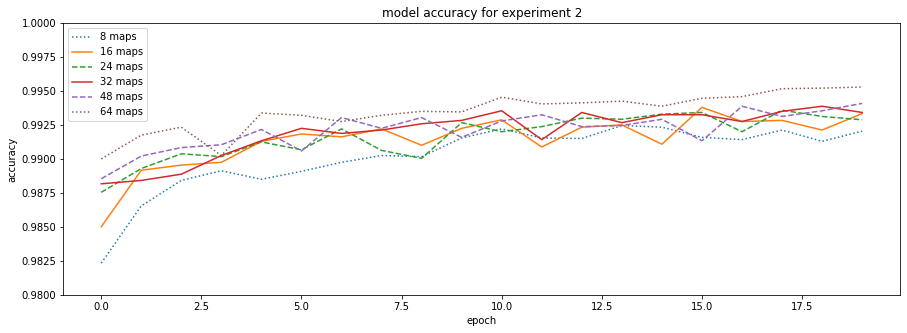

In [26]:
plt.figure(figsize=(15,5))

plt.plot(models_history[0].history['val_accuracy'], linestyle=':')
plt.plot(models_history[1].history['val_accuracy'], linestyle='-')
plt.plot(models_history[2].history['val_accuracy'], linestyle='--')
plt.plot(models_history[3].history['val_accuracy'], linestyle='-')
plt.plot(models_history[4].history['val_accuracy'], linestyle='--')
plt.plot(models_history[5].history['val_accuracy'], linestyle=':')

plt.title('model accuracy for experiment 2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(models_type, loc='upper left')

axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

## 5. Experiment 3: Dense Layer

The dense layer is the last layer before the output, in this experiment will experiment how big a dense layer value suits in this case.

We are going to experiment the dense layer size of 0, 32, 64, 128, 256, 512, 1024, and 2048 each.

In [29]:
nn = 8
models = [0] * nn

tf.random.set_seed(42)

for i in range(nn):
    inputs = Input(shape=(28, 28, 1), dtype=tf.float32)
    x = Conv2D(48, kernel_size=5, padding="same", activation="relu")(inputs)
    x = MaxPool2D()(x)
    x = Conv2D(96, kernel_size=5, padding="same", activation="relu")(x) 
    x = MaxPool2D()(x)
    x = Flatten()(x)
    
    if i > 0:
        x = Dense(2**(i+4), activation="relu")(x)
    
    outputs = Dense(10, activation="softmax")(x)
    models[i] = tf.keras.Model(inputs, outputs)

    models[i].compile(
        loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )

    models[i].summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 28, 28, 48)        1248      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 14, 14, 48)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 14, 14, 96)        115296    
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 7, 7, 96)          0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 4704)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 10)                470

In [30]:
models_history = [0] * nn
models_type = ["0", "32", "64", "128", "256", "512", "1024", "2048"]

for i in range(nn):
    models_history[i] = models[i].fit(
        train_ds,
        steps_per_epoch=len(train_ds),
        epochs=20,
        validation_data=val_ds,
        validation_steps=len(val_ds),
        callbacks=[lrscheduler], 
        verbose=0
    )
    print(f"{models_type[i]}: Epochs={20}, Train accuracy={max(models_history[i].history['accuracy']):.5f}, Validation accuracy={max(models_history[i].history['val_accuracy']):.5f}")
    print()

0: Epochs=20, Train accuracy=0.99998, Validation accuracy=0.99317

32: Epochs=20, Train accuracy=0.99989, Validation accuracy=0.99317

64: Epochs=20, Train accuracy=0.99991, Validation accuracy=0.99333

128: Epochs=20, Train accuracy=0.99988, Validation accuracy=0.99454

256: Epochs=20, Train accuracy=0.99991, Validation accuracy=0.99421

512: Epochs=20, Train accuracy=0.99984, Validation accuracy=0.99400

1024: Epochs=20, Train accuracy=0.99994, Validation accuracy=0.99467

2048: Epochs=20, Train accuracy=0.99990, Validation accuracy=0.99421



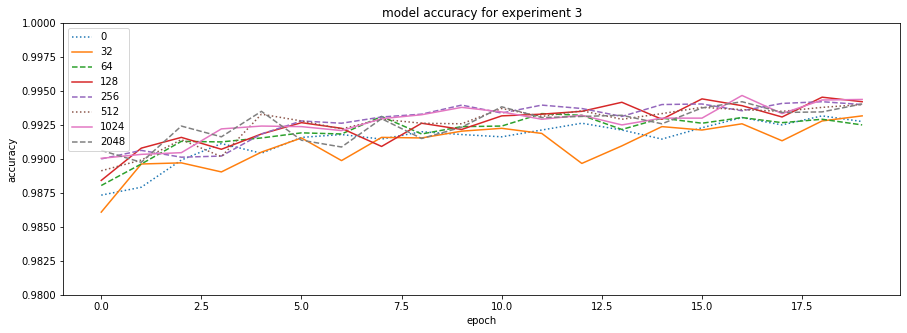

In [31]:
plt.figure(figsize=(15,5))

plt.plot(models_history[0].history['val_accuracy'], linestyle=':')
plt.plot(models_history[1].history['val_accuracy'], linestyle='-')
plt.plot(models_history[2].history['val_accuracy'], linestyle='--')
plt.plot(models_history[3].history['val_accuracy'], linestyle='-')
plt.plot(models_history[4].history['val_accuracy'], linestyle='--')
plt.plot(models_history[5].history['val_accuracy'], linestyle=':')
plt.plot(models_history[6].history['val_accuracy'], linestyle='-')
plt.plot(models_history[7].history['val_accuracy'], linestyle='--')

plt.title('model accuracy for experiment 3')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(models_type, loc='upper left')

axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

## 6. Experiment 4: Dropout

To prevent our model from overfitting, let's experiment using dropout layers.

In this case we are going to experiment the value of dropout layers that is suitable for our case which are 0%, 10%, 20%, 30%, 40%, 50%, 60%, or 70%.

In [34]:
nn = 8
models = [0] * nn

tf.random.set_seed(42)

for i in range(nn):
    inputs = Input(shape=(28, 28, 1), dtype=tf.float32)
    
    x = Conv2D(48, kernel_size=5, padding="same", activation="relu")(inputs)
    x = MaxPool2D()(x)
    x = Dropout(i * 0.1)(x)
    
    x = Conv2D(96, kernel_size=5, padding="same", activation="relu")(x) 
    x = MaxPool2D()(x)
    x = Dropout(i * 0.1)(x)
    
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(i * 0.1)(x)
    
    outputs = Dense(10, activation="softmax")(x)
    models[i] = tf.keras.Model(inputs, outputs)

    models[i].compile(
        loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )

    models[i].summary()

Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 28, 28, 48)        1248      
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 14, 14, 48)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 14, 14, 48)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 14, 14, 96)        115296    
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 7, 7, 96)          0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 7, 7, 96)          0  

In [35]:
models_history = [0] * nn
models_type = ["None","0.1","0.2","0.3","0.4","0.5", "0.6", "0.7"]

for i in range(nn):
    models_history[i] = models[i].fit(
        train_ds,
        steps_per_epoch=len(train_ds),
        epochs=20,
        validation_data=val_ds,
        validation_steps=len(val_ds),
        callbacks=[lrscheduler], 
        verbose=0
    )
    print(f"{models_type[i]}: Epochs={20}, Train accuracy={max(models_history[i].history['accuracy']):.5f}, Validation accuracy={max(models_history[i].history['val_accuracy']):.5f}")
    print()

None: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99496

0.1: Epochs=20, Train accuracy=0.99967, Validation accuracy=0.99421

0.2: Epochs=20, Train accuracy=0.99935, Validation accuracy=0.99496

0.3: Epochs=20, Train accuracy=0.99881, Validation accuracy=0.99496

0.4: Epochs=20, Train accuracy=0.99823, Validation accuracy=0.99500

0.5: Epochs=20, Train accuracy=0.99585, Validation accuracy=0.99479

0.6: Epochs=20, Train accuracy=0.99239, Validation accuracy=0.99517

0.7: Epochs=20, Train accuracy=0.98643, Validation accuracy=0.99371



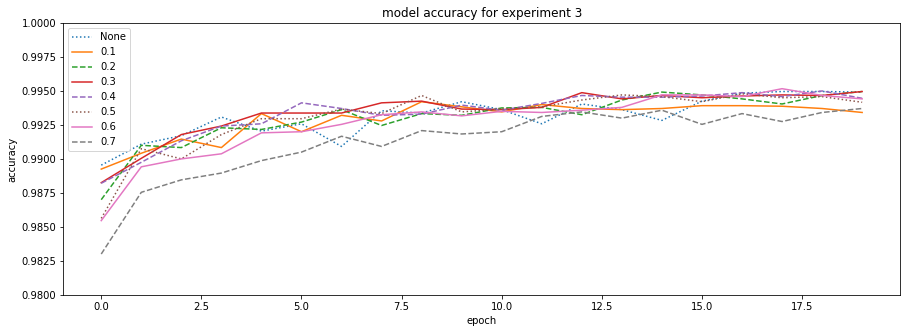

In [36]:
plt.figure(figsize=(15,5))

plt.plot(models_history[0].history['val_accuracy'], linestyle=':')
plt.plot(models_history[1].history['val_accuracy'], linestyle='-')
plt.plot(models_history[2].history['val_accuracy'], linestyle='--')
plt.plot(models_history[3].history['val_accuracy'], linestyle='-')
plt.plot(models_history[4].history['val_accuracy'], linestyle='--')
plt.plot(models_history[5].history['val_accuracy'], linestyle=':')
plt.plot(models_history[6].history['val_accuracy'], linestyle='-')
plt.plot(models_history[7].history['val_accuracy'], linestyle='--')

plt.title('model accuracy for experiment 3')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(models_type, loc='upper left')

axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

## 7. Putting it all in

We are going to put our experiments into a big dog model, but this time we are going to add `BatchNormalization` layers as well.

In [37]:
nn = 5
models = [0] * nn

### Model 1

In [48]:
tf.random.set_seed(42)

inputs = Input(shape=(28, 28, 1), dtype=tf.float32)
x = Conv2D(48, kernel_size=5, activation="relu")(inputs)
x = MaxPool2D()(x)
x = Dropout(0.6)(x)

x = Conv2D(96, kernel_size=5, activation="relu")(x) 
x = MaxPool2D()(x)
x = Dropout(0.6)(x)

x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.6)(x)

outputs = Dense(10, activation="softmax")(x)
models[0] = tf.keras.Model(inputs, outputs)

models[0].compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

models[0].summary()

Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 24, 24, 48)        1248      
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 12, 12, 48)        0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 12, 12, 48)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 8, 8, 96)          115296    
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 4, 4, 96)          0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 4, 4, 96)          0  

### Model 2

In [49]:
tf.random.set_seed(42)

inputs = Input(shape=(28, 28, 1), dtype=tf.float32)
x = Conv2D(48, kernel_size=3, activation="relu")(inputs)
x = Conv2D(48, kernel_size=3, activation="relu")(x) # add one more Conv2D layer
x = MaxPool2D()(x)
x = Dropout(0.6)(x)

x = Conv2D(96, kernel_size=3, activation="relu")(x)
x = Conv2D(96, kernel_size=3, activation="relu")(x) # add one more Conv2D layer
x = MaxPool2D()(x)
x = Dropout(0.6)(x)

x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.6)(x)

outputs = Dense(10, activation="softmax")(x)
models[1] = tf.keras.Model(inputs, outputs)

models[1].compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

models[1].summary()

Model: "model_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 26, 26, 48)        480       
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 24, 24, 48)        20784     
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 12, 12, 48)        0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 12, 12, 48)        0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 10, 10, 96)        41568     
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 8, 8, 96)          830

### Model 3

In [50]:
tf.random.set_seed(42)

inputs = Input(shape=(28, 28, 1), dtype=tf.float32)

# kernel size of 5
x = Conv2D(48, kernel_size=5, activation="relu")(inputs)
x = Conv2D(48, kernel_size=5, strides=2, padding="same", activation="relu")(x) 
# no maxpooling layers
x = Dropout(0.6)(x)

x = Conv2D(96, kernel_size=5, activation="relu")(x)
x = Conv2D(96, kernel_size=5, strides=2, padding="same", activation="relu")(x) 
# no maxpooling layers
x = Dropout(0.6)(x)

x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.6)(x)

outputs = Dense(10, activation="softmax")(x)
models[2] = tf.keras.Model(inputs, outputs)

models[2].compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

models[2].summary()

Model: "model_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 24, 24, 48)        1248      
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 12, 12, 48)        57648     
_________________________________________________________________
dropout_72 (Dropout)         (None, 12, 12, 48)        0         
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 8, 8, 96)          115296    
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 4, 4, 96)          230496    
_________________________________________________________________
dropout_73 (Dropout)         (None, 4, 4, 96)          0  

### Model 4

In [51]:
tf.random.set_seed(42)

inputs = Input(shape=(28, 28, 1), dtype=tf.float32)

x = Conv2D(48, kernel_size=3, activation="relu")(inputs)
x = BatchNormalization()(x) # adding BatchNormalization layer after Conv2D
x = Conv2D(48, kernel_size=3, activation="relu")(x)
x = BatchNormalization()(x) # adding BatchNormalization layer after Conv2D
x = Conv2D(48, kernel_size=5, strides=2, padding="same", activation="relu")(x) # kernel size = 5
x = BatchNormalization()(x) # adding BatchNormalization layer after Conv2D
x = Dropout(0.6)(x)

x = Conv2D(96, kernel_size=3, activation="relu")(x)
x = BatchNormalization()(x) # adding BatchNormalization layer after Conv2D
x = Conv2D(96, kernel_size=3, activation="relu")(x)
x = BatchNormalization()(x) # adding BatchNormalization layer after Conv2D
x = Conv2D(96, kernel_size=5, strides=2, padding="same", activation="relu")(x) # kernel size = 5
x = BatchNormalization()(x) # adding BatchNormalization layer after Conv2D
x = Dropout(0.6)(x)

x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.6)(x)

outputs = Dense(10, activation="softmax")(x)
models[3] = tf.keras.Model(inputs, outputs)

models[3].compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

models[3].summary()

Model: "model_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 26, 26, 48)        480       
_________________________________________________________________
batch_normalization_19 (Batc (None, 26, 26, 48)        192       
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 24, 24, 48)        20784     
_________________________________________________________________
batch_normalization_20 (Batc (None, 24, 24, 48)        192       
_________________________________________________________________
conv2d_134 (Conv2D)          (None, 12, 12, 48)        57648     
_________________________________________________________________
batch_normalization_21 (Batc (None, 12, 12, 48)        192

### Model 5

#### Adding data augmentation for model 5

In [66]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=42, shuffle=True, test_size=0.2)

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [67]:
train_gen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_ds_aug = train_gen.flow(
    X_train,
    y_train,
    batch_size=80
)

In [54]:
tf.random.set_seed(42)

inputs = Input(shape=(28, 28, 1), dtype=tf.float32)

x = Conv2D(48, kernel_size=3, activation="relu")(inputs)
x = BatchNormalization()(x)
x = Conv2D(48, kernel_size=3, activation="relu")(x)
x = BatchNormalization()(x)
x = Conv2D(48, kernel_size=5, strides=2, padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)

x = Conv2D(96, kernel_size=3, activation="relu")(x)
x = BatchNormalization()(x)
x = Conv2D(96, kernel_size=3, activation="relu")(x)
x = BatchNormalization()(x)
x = Conv2D(96, kernel_size=5, strides=2, padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)

x = Flatten()(x)
x = Dense(1024 , activation="relu")(x)
x = BatchNormalization()(x) # adding BatchNormalization layer after Dense layer
x = Dropout(0.6)(x)

outputs = Dense(10, activation="softmax")(x)
models[4] = tf.keras.Model(inputs, outputs)

models[4].compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

models[4].summary()

Model: "model_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 26, 26, 48)        480       
_________________________________________________________________
batch_normalization_25 (Batc (None, 26, 26, 48)        192       
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 24, 24, 48)        20784     
_________________________________________________________________
batch_normalization_26 (Batc (None, 24, 24, 48)        192       
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 12, 12, 48)        57648     
_________________________________________________________________
batch_normalization_27 (Batc (None, 12, 12, 48)        192

### Training

In [55]:
models_history = [0] * nn
models_type = ["basic", "ss layers + 1 cv2d", "no mp", "bn", "bn+aug"]

# Model 1 - 4
for i in range(nn-1):
    models_history[i] = models[i].fit(
        train_ds,
        steps_per_epoch=len(train_ds),
        epochs=20,
        validation_data=val_ds,
        validation_steps=len(val_ds),
        callbacks=[lrscheduler], 
        verbose=0
    )
    print(f"{models_type[i]}: Epochs={20}, Train accuracy={max(models_history[i].history['accuracy']):.5f}, Validation accuracy={max(models_history[i].history['val_accuracy']):.5f}")
    print()

# Model 5
models_history[-1] = models[-1].fit(
    train_ds_aug,
    steps_per_epoch=len(train_ds_aug),
    epochs=20,
    validation_data=val_ds,
    validation_steps=len(val_ds),
    callbacks=[lrscheduler], 
    verbose=0
)
print(f"{models_type[-1]}: Epochs={20}, Train accuracy={max(models_history[-1].history['accuracy']):.5f}, Validation accuracy={max(models_history[-1].history['val_accuracy']):.5f}")

basic: Epochs=20, Train accuracy=0.99094, Validation accuracy=0.99454

ss layers + 1 cv2d: Epochs=20, Train accuracy=0.99415, Validation accuracy=0.99521

no mp: Epochs=20, Train accuracy=0.99560, Validation accuracy=0.99537

bn: Epochs=20, Train accuracy=0.99641, Validation accuracy=0.99521

bn+aug: Epochs=20, Train accuracy=0.09901, Validation accuracy=0.99537


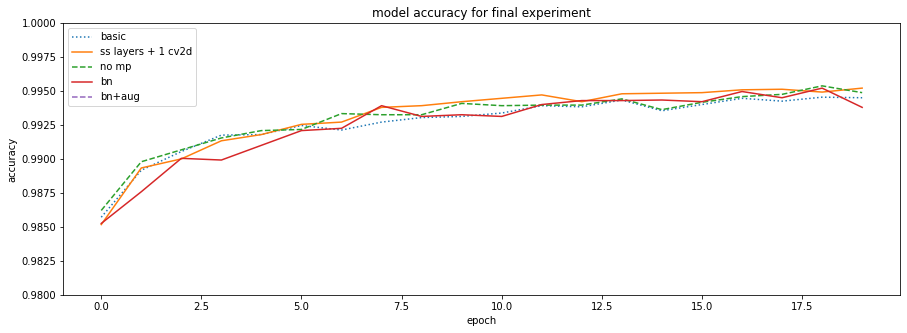

In [63]:
plt.figure(figsize=(15,5))

plt.plot(models_history[0].history['val_accuracy'], linestyle=':')
plt.plot(models_history[1].history['val_accuracy'], linestyle='-')
plt.plot(models_history[2].history['val_accuracy'], linestyle='--')
plt.plot(models_history[3].history['val_accuracy'], linestyle='-')
plt.plot(models_history[4].history['val_accuracy'], linestyle='--')

plt.title('model accuracy for final experiment')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(models_type, loc='upper left')

axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

## 8. Submit predictions

In [73]:
# Our best model
models[3].fit(
        train_ds_aug,
        steps_per_epoch=len(train_ds_aug),
        epochs=20,
        validation_data=val_ds,
        validation_steps=len(val_ds),
        callbacks=[lrscheduler], 
        verbose=1
    )

Epoch 1/20
1200/1200 [==============================] - 31s 25ms/step - loss: 0.0736 - accuracy: 0.9798 - val_loss: 0.0251 - val_accuracy: 0.9936
Epoch 2/20
1200/1200 [==============================] - 32s 27ms/step - loss: 0.0468 - accuracy: 0.9864 - val_loss: 0.0216 - val_accuracy: 0.9948
Epoch 3/20
1200/1200 [==============================] - 30s 25ms/step - loss: 0.0405 - accuracy: 0.9883 - val_loss: 0.0206 - val_accuracy: 0.9951
Epoch 4/20
1200/1200 [==============================] - 31s 26ms/step - loss: 0.0386 - accuracy: 0.9893 - val_loss: 0.0202 - val_accuracy: 0.9944
Epoch 5/20
1200/1200 [==============================] - 31s 26ms/step - loss: 0.0345 - accuracy: 0.9901 - val_loss: 0.0201 - val_accuracy: 0.9950curacy: 0.
Epoch 6/20
1200/1200 [==============================] - 31s 26ms/step - loss: 0.0335 - accuracy: 0.9906 - val_loss: 0.0177 - val_accuracy: 0.9956
Epoch 7/20
1200/1200 [==============================] - 30s 25ms/step - loss: 0.0302 - accuracy: 0.9911 - val_loss

In [75]:
test_data = pd.read_csv("data/test.csv")
test = test_data / 255.
test = test.values.reshape(-1, 28, 28, 1)

# Predict then submit
results = models[3].predict(test)
results = np.argmax(results, axis=1)
results = pd.Series(results, name="Label")
submission = pd.concat([pd.Series(range(1,28001),name="ImageId"), results], axis=1)
submission.to_csv("predictions_mnist.csv", index=False)